# Sparse Variational Dropout 
 Attention: The code is not highly tuned but it is simple.

In [1]:
!pip3 install tabulate
!pip3 install torch==1.1.0 torchvision==0.3.0 -f https://download.pytorch.org/whl/torch_stable.html
!wget https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/master/assignments/local_logger.py  

Looking in links: https://download.pytorch.org/whl/torch_stable.html
--2019-08-24 15:46:54--  https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/master/assignments/local_logger.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2423 (2.4K) [text/plain]
Saving to: ‘local_logger.py.1’

local_logger.py.1   100%[===================>]   2.37K  --.-KB/s    in 0s      

2019-08-24 15:46:54 (62.1 MB/s) - ‘local_logger.py.1’ saved [2423/2423]



# Implementation

In [0]:
import math
import torch
import time
import numpy as np

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from local_logger import Logger
from torch.nn import Parameter
from torchvision import datasets, transforms

In [0]:
class LinearSVDO(nn.Module):
    def __init__(self, in_features, out_features, threshold, bias=True):
        super(LinearSVDO, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.threshold = threshold

        self.W = Parameter(torch.Tensor(out_features, in_features))
        self.log_sigma = Parameter(torch.Tensor(out_features, in_features))
        self.bias = Parameter(torch.Tensor(1, out_features))
        
        self.reset_parameters()

    def reset_parameters(self):
        self.bias.data.zero_()
        self.W.data.normal_(0, 0.02)
        self.log_sigma.data.fill_(-5)        
        
    def forward(self, x):
        self.log_alpha = self.log_sigma * 2.0 - 2.0 * torch.log(1e-16 + torch.abs(self.W))
        self.log_alpha = torch.clamp(self.log_alpha, -10, 10) 
        
        if self.training:
            lrt_mean =  F.linear(x, self.W) + self.bias
            lrt_std = torch.sqrt(F.linear(x * x, torch.exp(self.log_sigma * 2.0)) + 1e-8)
            eps = lrt_std.data.new(lrt_std.size()).normal_()
            return lrt_mean + lrt_std * eps
    
        return F.linear(x, self.W * (self.log_alpha < 3).float()) + self.bias
        
    def kl_reg(self):
        # Return KL here -- a scalar 
        k1, k2, k3 = torch.Tensor([0.63576]).cuda(), torch.Tensor([1.8732]).cuda(), torch.Tensor([1.48695]).cuda()
        kl = k1 * torch.sigmoid(k2 + k3 * self.log_alpha) - 0.5 * torch.log1p(torch.exp(-self.log_alpha))
        a = - torch.sum(kl)
        return a

In [0]:
# Define a simple 2 layer Network
class Net(nn.Module):
    def __init__(self, threshold):
        super(Net, self).__init__()
        self.fc1 = LinearSVDO(28*28, 300, threshold)
        self.fc2 = LinearSVDO(300,  100, threshold)
        self.fc3 = LinearSVDO(100,  10, threshold)
        self.threshold=threshold

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

In [0]:
# Load a dataset
def get_mnist(batch_size):
    trsnform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=True, download=True,
        transform=trsnform), batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, download=True,
        transform=trsnform), batch_size=batch_size, shuffle=True, num_workers=4)

    return train_loader, test_loader

In [0]:
# Define New Loss Function -- SGVLB 
class SGVLB(nn.Module):
    def __init__(self, net, train_size):
        super(SGVLB, self).__init__()
        self.train_size = train_size
        self.net = net

    def forward(self, input, target, kl_weight=1.0):
        assert not target.requires_grad
        kl = 0.0
        for module in self.net.children():
            if hasattr(module, 'kl_reg'):
                kl = kl + module.kl_reg()
        return F.cross_entropy(input, target) * self.train_size + kl_weight * kl

In [0]:
model = Net(threshold=3).cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,60,70,80], gamma=0.2)

fmt = {'tr_los': '3.1e', 'te_loss': '3.1e', 'sp_0': '.3f', 'sp_1': '.3f', 'lr': '3.1e', 'kl': '.2f'}
logger = Logger('sparse_vd', fmt=fmt)

train_loader, test_loader = get_mnist(batch_size=100)
sgvlb = SGVLB(model, len(train_loader.dataset)).cuda()

In [8]:
kl_weight = 0.02
epochs = 100

for epoch in range(1, epochs + 1):
    start = time.time()
    scheduler.step()
    model.train()
    train_loss, train_acc = 0, 0 
    kl_weight = min(kl_weight+0.02, 1)
    logger.add_scalar(epoch, 'kl', kl_weight)
    logger.add_scalar(epoch, 'lr', scheduler.get_lr()[0])
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.cuda()
        target = target.cuda()
        data = data.view(-1, 28*28)
        optimizer.zero_grad()
        
        output = model(data)
        pred = output.data.max(1)[1] 
        loss = sgvlb(output, target, kl_weight)
        loss.backward()
        optimizer.step()
        
        train_loss += loss 
        train_acc += np.sum(pred.cpu().numpy() == target.cpu().data.numpy())

    logger.add_scalar(epoch, 'tr_los', train_loss / len(train_loader.dataset))
    logger.add_scalar(epoch, 'tr_acc', train_acc / len(train_loader.dataset) * 100)
    
    
    model.eval()
    test_loss, test_acc = 0, 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.cuda()
        target = target.cuda()
        data = data.view(-1, 28*28)
        output = model(data)
        test_loss += float(sgvlb(output, target, kl_weight))
        pred = output.data.max(1)[1] 
        test_acc += np.sum(pred.cpu().numpy() == target.cpu().data.numpy())
        
    logger.add_scalar(epoch, 'te_loss', test_loss / len(test_loader.dataset))
    logger.add_scalar(epoch, 'te_acc', test_acc / len(test_loader.dataset) * 100)
    
    for i, c in enumerate(model.children()):
        if hasattr(c, 'kl_reg'):
            logger.add_scalar(epoch, 'sp_%s' % i, (c.log_alpha.cpu().data.numpy() > model.threshold).mean())
    
    end = time.time()  
    logger.add_scalar(epoch, 'time', end - start)
            
    logger.iter_info()

  epoch    kl       lr    tr_los    tr_acc    te_loss    te_acc    sp_0    sp_1    sp_2    time
-------  ----  -------  --------  --------  ---------  --------  ------  ------  ------  ------
      1  0.04  1.0e-03   2.0e+02      90.8    7.2e+01      95.7   0.379   0.121     0.0    11.6
      2  0.06  1.0e-03   4.2e+01      96.3    1.7e+01      97.0   0.470   0.216     0.0    11.6
      3  0.08  1.0e-03  -1.7e+01      97.3   -2.6e+01      97.1   0.562   0.303     0.0    11.7
      4  0.10  1.0e-03  -6.5e+01      97.7   -7.4e+01      97.6   0.658   0.388     0.1    11.6
      5  0.12  1.0e-03  -1.1e+02      97.9   -1.1e+02      97.6   0.679   0.417     0.0    11.7
      6  0.14  1.0e-03  -1.5e+02      98.0   -1.5e+02      97.7   0.751   0.485     0.1    11.7
      7  0.16  1.0e-03  -1.8e+02      98.1   -1.8e+02      97.7   0.763   0.495     0.1    11.8
      8  0.18  1.0e-03  -2.2e+02      98.2   -2.2e+02      97.9   0.803   0.545     0.1    11.8
      9  0.20  1.0e-03  -2.5e+02      98

In [9]:
all_w, kep_w = 0, 0

for c in model.children():
    kep_w += (c.log_alpha.cpu().data.numpy() < model.threshold).sum()
    all_w += c.log_alpha.cpu().data.numpy().size

print('keept weight ratio =', all_w/kep_w)

keept weight ratio = 32.90075392411321


    # Good result should be like 
    #   epoch    kl       lr    tr_los    tr_acc    te_loss    te_acc    sp_0    sp_1
    #  -------  ----  -------  --------  --------  ---------  --------  ------  ------
    #      100     1  1.6e-06  -1.4e+03      98.0   -1.4e+03      98.3   0.969   0.760
    # keept weight ratio = 30.109973454683352

# Visualization

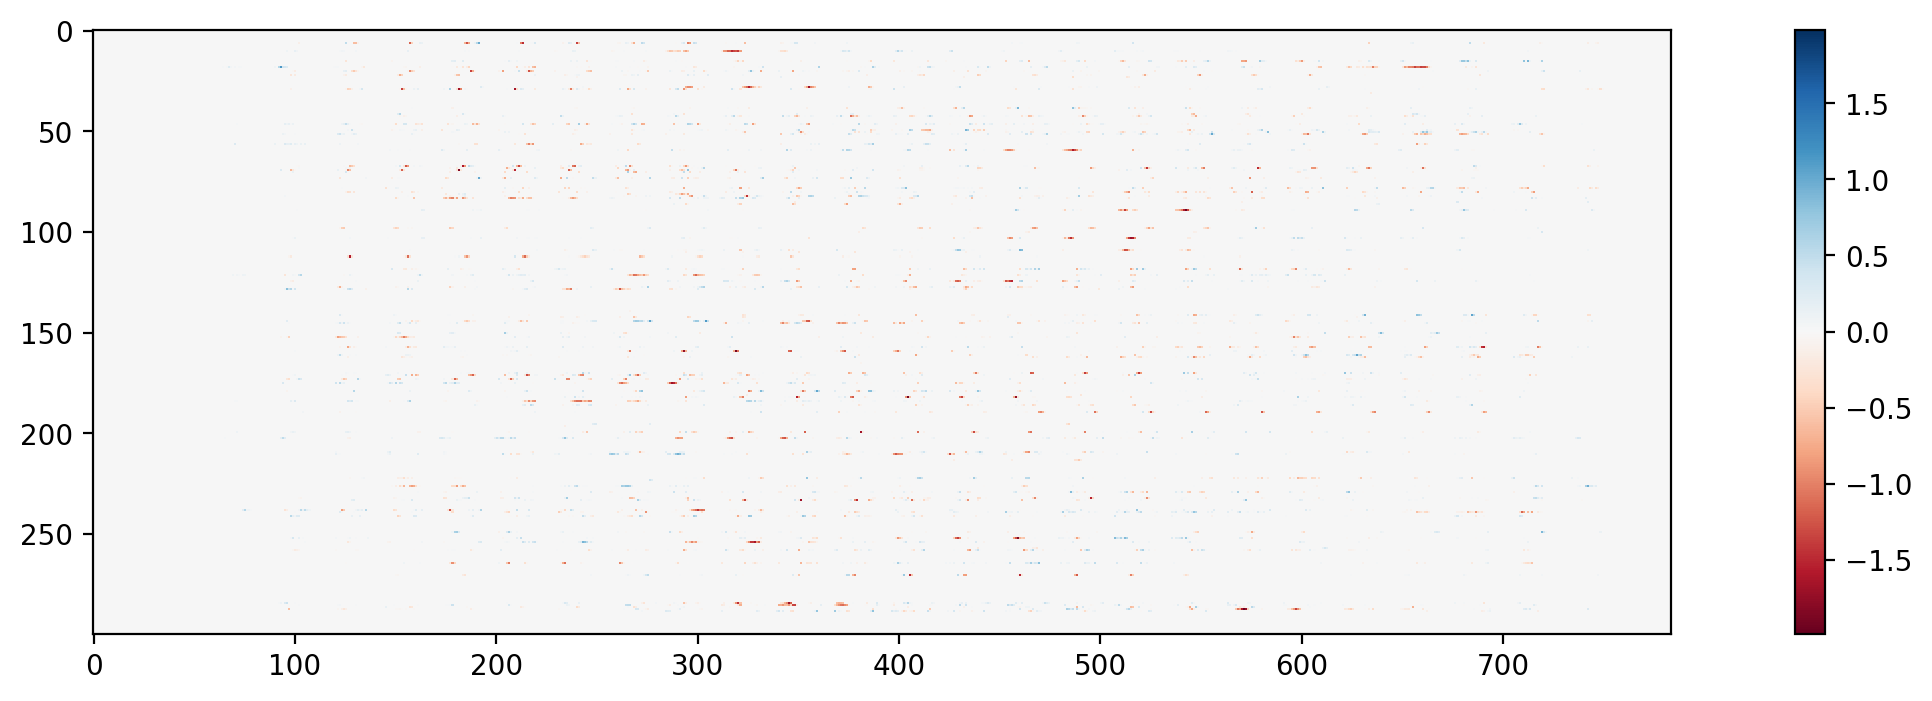

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl

from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 4
rcParams['figure.dpi'] = 200


log_alpha = (model.fc1.log_alpha.cpu().detach().numpy() < 3).astype(np.float)
W = model.fc1.W.cpu().detach().numpy()

# Normalize color map
max_val = np.max(np.abs(log_alpha * W))
norm = mpl.colors.Normalize(vmin=-max_val,vmax=max_val)

plt.imshow(log_alpha * W, cmap='RdBu', interpolation=None, norm=norm)
plt.colorbar()

(-0.5, 419.5, 419.5, -0.5)

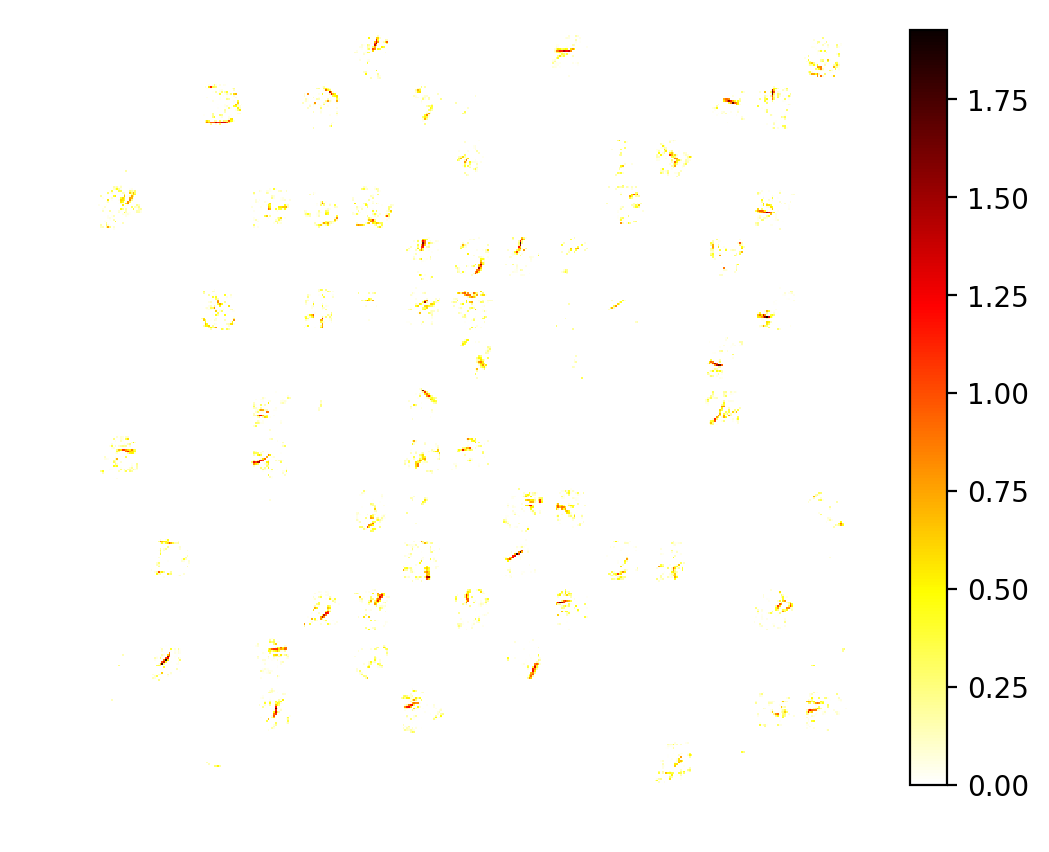

In [11]:
s = 0
from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 5

z = np.zeros((28*15, 28*15))

for i in range(15):
    for j in range(15):
        s += 1
        z[i*28:(i+1)*28, j*28:(j+1)*28] =  np.abs((log_alpha * W)[s].reshape(28, 28))
        
plt.imshow(z, cmap='hot_r')
plt.colorbar()
plt.axis('off')

# Compression with Sparse Matrixes

In [12]:
import scipy
import numpy as np
from scipy.sparse import csc_matrix, csc_matrix, coo_matrix, dok_matrix

row, col, data = [], [], []
M = list(model.children())[0].W.data.numpy()
LA = list(model.children())[0].log_alpha.data.numpy()

for i in range(300):
    for j in range(28*28):
        if LA[i, j] < 3:
            row += [i]
            col += [j]
            data += [M[i, j]]

Mcsr = csc_matrix((data, (row, col)), shape=(300, 28*28))
Mcsc = csc_matrix((data, (row, col)), shape=(300, 28*28))
Mcoo = coo_matrix((data, (row, col)), shape=(300, 28*28))

TypeError: ignored

In [0]:
np.savez_compressed('M_w', M)
scipy.sparse.save_npz('Mcsr_w', Mcsr)
scipy.sparse.save_npz('Mcsc_w', Mcsc)
scipy.sparse.save_npz('Mcoo_w', Mcoo)

In [0]:
ls -lah | grep _w